Creating a Synthetic Dataset


In [1]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(42)

# Parameters for the dataset
num_users = 1000  # Number of users
regions = ['North America', 'Europe', 'Asia', 'South America']

# Simulate user data
user_ids = np.arange(1, num_users + 1)  # User IDs from 1 to 1000
regions_data = np.random.choice(regions, size=num_users)  # Random region assignment

# Time spent streaming music before the campaign (in minutes)
time_spent_before = np.random.normal(60, 10, num_users)  # Normally distributed

# Assign random campaign exposure (1 for exposed, 0 for not exposed)
campaign_exposure = np.random.binomial(1, 0.5, num_users)

# Time spent after the campaign
# Users exposed to the campaign spend more time on average
time_spent_after = time_spent_before + campaign_exposure * np.random.normal(20, 5, num_users)

# Create a DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'region': regions_data,
    'campaign_exposure': campaign_exposure,
    'time_spent_before': time_spent_before,
    'time_spent_after': time_spent_after
})

# Display the first few rows of the dataset
print(df.head())


   user_id         region  campaign_exposure  time_spent_before  \
0        1           Asia                  1          63.417560   
1        2  South America                  1          78.761708   
2        3  North America                  0          69.504238   
3        4           Asia                  1          54.230963   
4        5           Asia                  0          51.015853   

   time_spent_after  
0         75.426938  
1        101.072572  
2         69.504238  
3         67.415093  
4         51.015853  


Performing the Randomized Controlled Trial (RCT)

In [2]:
# Split the data into two groups: Treatment (exposed) and Control (not exposed)
treatment_group = df[df['campaign_exposure'] == 1]
control_group = df[df['campaign_exposure'] == 0]

# Calculate the average time spent after the campaign for both groups
avg_time_treatment = treatment_group['time_spent_after'].mean()
avg_time_control = control_group['time_spent_after'].mean()

# Print the results
print(f"Average time spent after the campaign (treatment group): {avg_time_treatment:.2f} minutes")
print(f"Average time spent after the campaign (control group): {avg_time_control:.2f} minutes")


Average time spent after the campaign (treatment group): 79.72 minutes
Average time spent after the campaign (control group): 60.79 minutes


Step 3: Statistical Significance Testing (T-test)


In [3]:
from scipy import stats

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(
    treatment_group['time_spent_after'],
    control_group['time_spent_after'],
    equal_var=False  # Welch's t-test, does not assume equal population variance
)

# Print the T-statistic and P-value
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Check if the result is statistically significant
if p_value < 0.05:
    print("The difference between the two groups is statistically significant!")
else:
    print("The difference between the two groups is not statistically significant.")


T-statistic: 28.23
P-value: 0.0000
The difference between the two groups is statistically significant!



Visualization of Results


<ipython-input-4-4359e679e9f0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=avg_times, palette=['blue', 'green'])


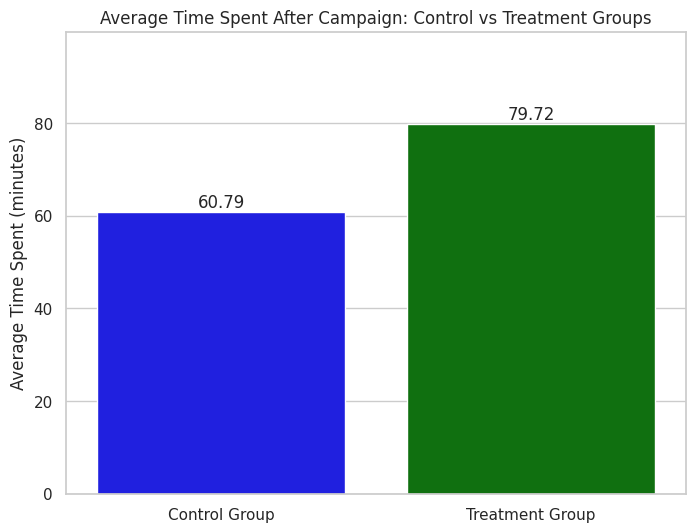

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Average time spent after the campaign for treatment and control groups
avg_times = [avg_time_control, avg_time_treatment]
labels = ['Control Group', 'Treatment Group']

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=avg_times, palette=['blue', 'green'])

# Add data labels on top of the bars
for index, value in enumerate(avg_times):
    plt.text(index, value + 1, f"{value:.2f}", ha='center')

plt.ylabel('Average Time Spent (minutes)')
plt.title('Average Time Spent After Campaign: Control vs Treatment Groups')
plt.ylim(0, max(avg_times) + 20)  # Adjust y-axis limit for better visualization
plt.show()


Analysis

Segmenting Analysis by Region

group         region    Control  Treatment
0               Asia  60.378859  80.832191
1             Europe  61.092375  79.846757
2      North America  60.767344  80.095650
3      South America  60.920151  78.494208


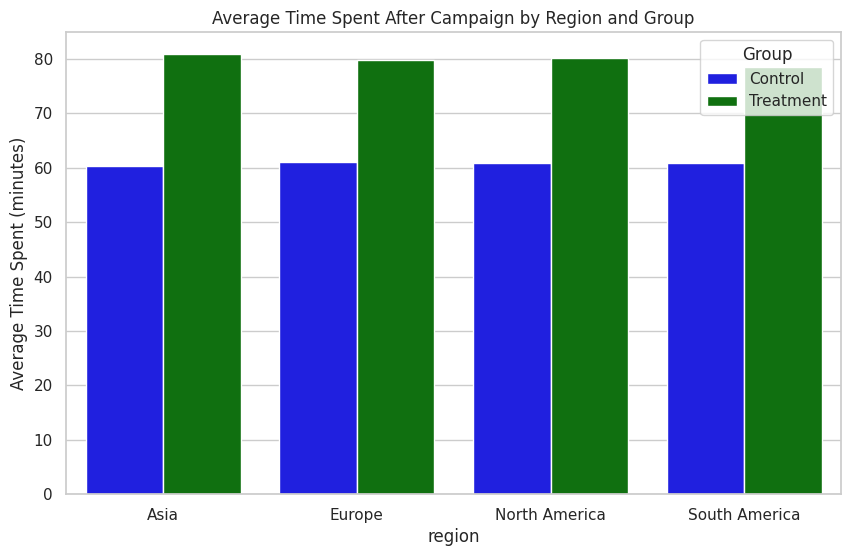

In [5]:
# Calculate average time spent after the campaign by region and exposure
region_analysis = df.groupby(['region', 'campaign_exposure'])['time_spent_after'].mean().reset_index()

# Rename for clarity
region_analysis['group'] = region_analysis['campaign_exposure'].map({0: 'Control', 1: 'Treatment'})

# Pivot the table for better visualization
region_pivot = region_analysis.pivot(index='region', columns='group', values='time_spent_after').reset_index()

print(region_pivot)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='time_spent_after', hue='group', data=region_analysis, palette=['blue', 'green'])

plt.ylabel('Average Time Spent (minutes)')
plt.title('Average Time Spent After Campaign by Region and Group')
plt.legend(title='Group')
plt.show()


Visualizing the Distribution of Time Spent

<ipython-input-6-2384680a4433>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='campaign_exposure', y='time_spent_after', data=df, palette=['blue', 'green'])


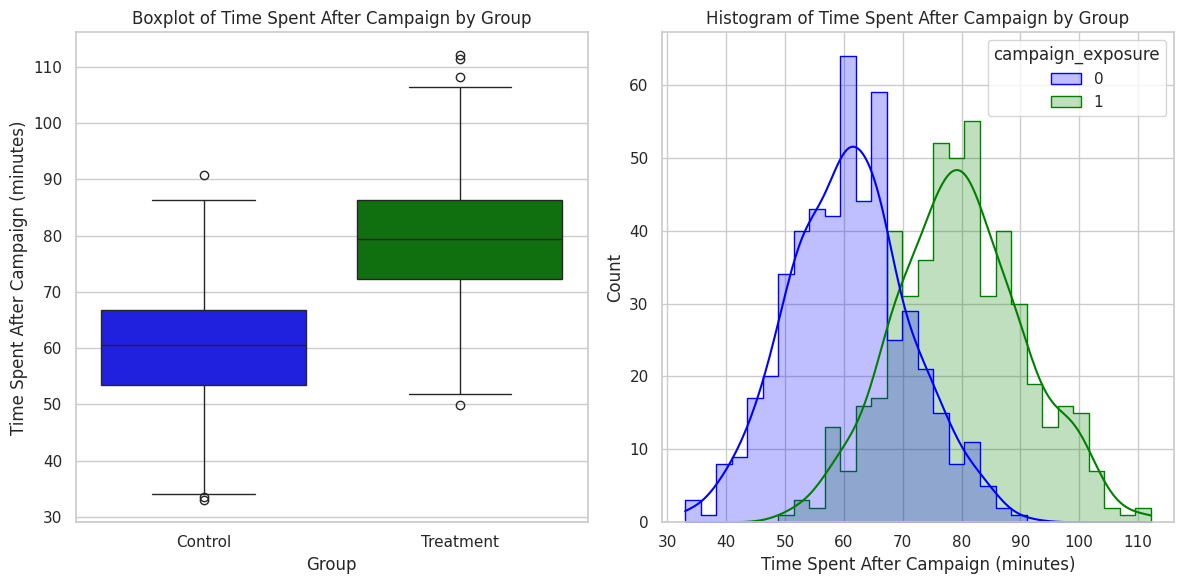

In [6]:
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='campaign_exposure', y='time_spent_after', data=df, palette=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Time Spent After Campaign (minutes)')
plt.title('Boxplot of Time Spent After Campaign by Group')
plt.xticks([0, 1], ['Control', 'Treatment'])

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='time_spent_after', hue='campaign_exposure', bins=30, kde=True, palette=['blue', 'green'], element='step')
plt.xlabel('Time Spent After Campaign (minutes)')
plt.title('Histogram of Time Spent After Campaign by Group')

plt.tight_layout()
plt.show()


Calculating Effect Size

In [7]:
from math import sqrt

# Calculate means and standard deviations
mean_treatment = treatment_group['time_spent_after'].mean()
mean_control = control_group['time_spent_after'].mean()
std_treatment = treatment_group['time_spent_after'].std()
std_control = control_group['time_spent_after'].std()

# Calculate pooled standard deviation
pooled_std = sqrt(((std_treatment ** 2) + (std_control ** 2)) / 2)

# Calculate Cohen's d
cohen_d = (mean_treatment - mean_control) / pooled_std

print(f"Cohen's d: {cohen_d:.2f}")

# Interpretation
if abs(cohen_d) < 0.2:
    print("Effect size is negligible.")
elif abs(cohen_d) < 0.5:
    print("Effect size is small.")
elif abs(cohen_d) < 0.8:
    print("Effect size is medium.")
else:
    print("Effect size is large.")


Cohen's d: 1.79
Effect size is large.


Regression Analysis to Control for Other Variables

campaign_exposure: The coefficient indicates the average difference in time_spent_after between the treatment and control groups, controlling for region and time_spent_before.
C(region): Adjusts for regional differences.
time_spent_before: Controls for baseline time spent.

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Convert 'campaign_exposure' to categorical
df['campaign_exposure'] = df['campaign_exposure'].astype('category')

# Build the regression model
model = smf.ols('time_spent_after ~ campaign_exposure + C(region) + time_spent_before', data=df).fit()

# Summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       time_spent_after   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     3269.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:48:41   Log-Likelihood:                -2642.7
No. Observations:                1000   AIC:                             5297.
Df Residuals:                     994   BIC:                             5327.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Investigating User Retention Post-Campaign


<ipython-input-9-3eea709cc88e>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_rates = df.groupby('campaign_exposure')['retained'].mean()
<ipython-input-9-3eea709cc88e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Control', 'Treatment'], y=retention_rates.values, palette=['blue', 'green'])


campaign_exposure
0    0.620758
1    0.815631
Name: retained, dtype: float64


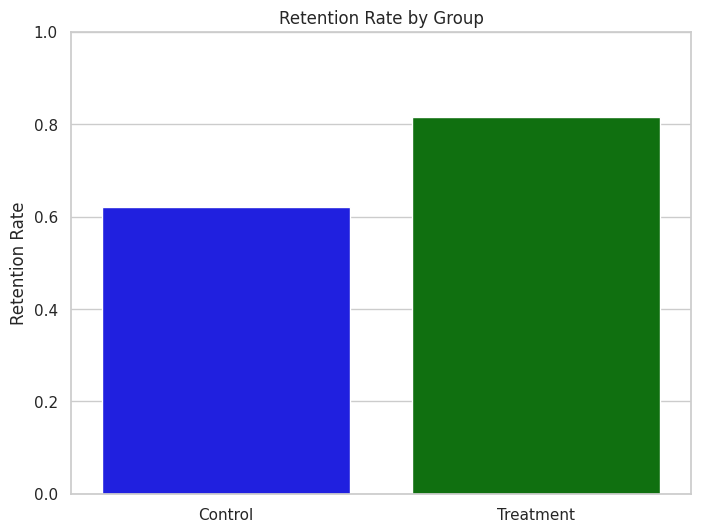

In [9]:
# Simulate retention data (e.g., whether the user remains active after the campaign)
# For the sake of this example, let's assume retention is influenced by time_spent_after
retention_prob = 1 / (1 + np.exp(-0.05 * (df['time_spent_after'] - 50)))  # Logistic function
df['retained'] = np.random.binomial(1, retention_prob)

# Calculate retention rates
retention_rates = df.groupby('campaign_exposure')['retained'].mean()

print(retention_rates)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=['Control', 'Treatment'], y=retention_rates.values, palette=['blue', 'green'])
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Group')
plt.ylim(0, 1)
plt.show()


Statistical Testing for Retention:



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set the random seed for reproducibility
np.random.seed(42)

# Parameters for the dataset
num_users = 1000  # Number of users
regions = ['North America', 'Europe', 'Asia', 'South America']

# Simulate user data
user_ids = np.arange(1, num_users + 1)  # User IDs from 1 to 1000
regions_data = np.random.choice(regions, size=num_users)  # Random region assignment

# Time spent streaming music before the campaign (in minutes)
time_spent_before = np.random.normal(60, 10, num_users)  # Normally distributed

# Assign random campaign exposure (1 for exposed, 0 for not exposed)
campaign_exposure = np.random.binomial(1, 0.5, num_users)

# Time spent after the campaign
# Users exposed to the campaign spend more time on average
time_spent_after = time_spent_before + campaign_exposure * np.random.normal(20, 5, num_users)

# Create a DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'region': regions_data,
    'campaign_exposure': campaign_exposure,
    'time_spent_before': time_spent_before,
    'time_spent_after': time_spent_after
})

# Step 9: Simulate Retention Data
retention_prob = 1 / (1 + np.exp(-0.05 * (df['time_spent_after'] - 50)))  # Logistic function
df['retained'] = np.random.binomial(1, retention_prob)

# Verify the creation of 'retained' column
print(df[['user_id', 'time_spent_after', 'retained']].head())

# Split the data into Treatment and Control groups
treatment_group = df[df['campaign_exposure'] == 1]
control_group = df[df['campaign_exposure'] == 0]

# Perform Chi-Square Test
contingency_table = pd.crosstab(df['campaign_exposure'], df['retained'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("Retention rates differ significantly between the groups.")
else:
    print("No significant difference in retention rates between the groups.")


   user_id  time_spent_after  retained
0        1         75.426938         0
1        2        101.072572         1
2        3         69.504238         1
3        4         67.415093         1
4        5         51.015853         1
Chi-square Statistic: 45.93
P-value: 0.0000
Retention rates differ significantly between the groups.


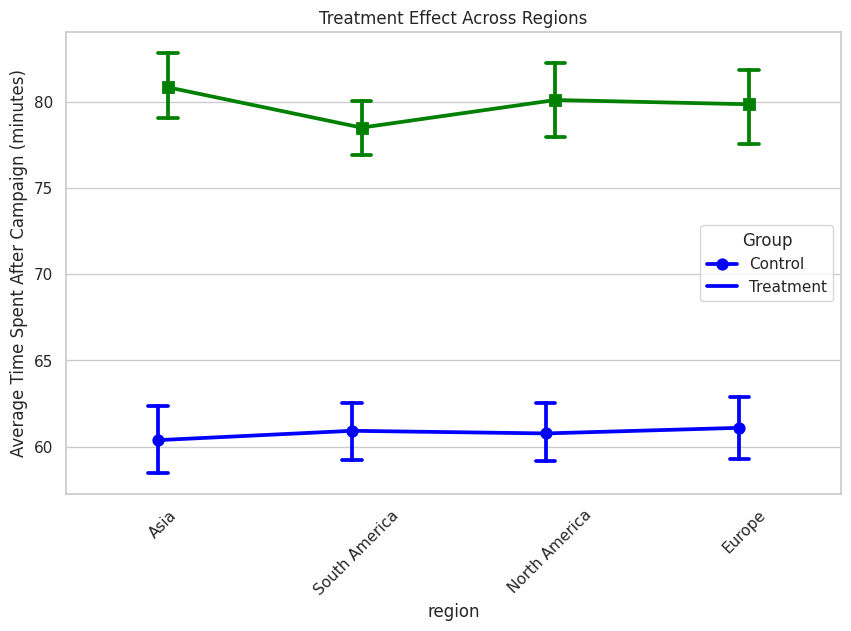

In [11]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='region', y='time_spent_after', hue='campaign_exposure', data=df, dodge=True, markers=['o', 's'], capsize=.1, palette=['blue', 'green'])

plt.ylabel('Average Time Spent After Campaign (minutes)')
plt.title('Treatment Effect Across Regions')
plt.legend(title='Group', labels=['Control', 'Treatment'])
plt.xticks(rotation=45)
plt.show()
